In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

print(torch.__version__)


2.6.0+cu124


#   Training deep neural network on GPU

In [4]:
from google.colab import files
uploaded = files.upload()  # This will allow you to select files from your local machine

Saving data.zip to data.zip


In [5]:
import zipfile
import os

# Specify the uploaded zip file's name
zip_filename = "data.zip"

# Create a directory to extract the files into
extracted_folder = "/content/extracted_data"  # You can change this path if needed

# Extract the zip file
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

print(f"Files extracted to {extracted_folder}")

Files extracted to /content/extracted_data


In [6]:
# List the files in the extracted folder
extracted_files = os.listdir(extracted_folder)
print(extracted_files)

['data']


In [47]:
dataset = MNIST(root='extracted_data/data/', download=False, transform= ToTensor())


In [48]:
# now lets used the random_split helper function to set aside 10000 images of our validation set.
val_size = 10000
train_size = len(dataset) - val_size

train_ds, vals_ds = random_split(dataset, [train_size,val_size])

len(train_ds), len(vals_ds)

(50000, 10000)

In [49]:
batch_size = 128

In [50]:
# we can now create pytroch data loaders for traning and validation
# Create DataLoaders for training and validation datasets
# num_workers: Number of subprocesses to use for data loading. More workers = faster data loading.
# pin_memory: If True, the data loader will copy Tensors into CUDA pinned memory (speeds up transfer to GPU).
train_loader = DataLoader(train_ds,batch_size, shuffle= True, num_workers= 4, pin_memory=True)
val_loader = DataLoader(vals_ds, batch_size*2, num_workers=4, pin_memory= True)


In [51]:
for images, _ in train_loader:
  print('images.shape',images.shape)
  break

#this will print 128 mean batch size and the 1 mean channel and then 28, 28 mean rows and columns

images.shape torch.Size([128, 1, 28, 28])


images.shape: torch.Size([128, 1, 28, 28])


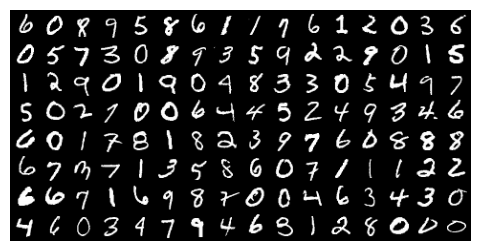

In [52]:
# Loop through the training data loader; we only need images for visualization, so we ignore labels using '_'
for images, _ in train_loader:

    # Print the shape of the batch of images (e.g., torch.Size([64, 1, 28, 28]))
    print('images.shape:', images.shape)

    # Create a matplotlib figure with width=16 inches and height=3 inches for displaying images in a row
    plt.figure(figsize=(16, 3))

    # Turn off the axis (no x or y ticks or labels) for a cleaner image display
    plt.axis('off')

    # Display a grid of images:
    # - make_grid arranges images into a grid format (e.g., 16 images per row)
    # - permute(1, 2, 0) changes image dimensions from [C, H, W] to [H, W, C] for matplotlib
    plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0))

    # Only visualize the first batch, so break the loop after one iteration
    break


**Model**

In [53]:
def accuracy(outputs, labels):
   _, preds = torch.max(outputs, dim =1)
   return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [86]:
class MnistModel(nn.Module):
    """Feedforward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, outsize):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, outsize)

    def forward(self, xb):
        # Flatten the images tensor
        xb = xb.view(xb.size(0), -1)
        # get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # apply activation function
        out = F.relu(out)
        # get prediction using output layer
        out = self.linear2(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)     # generate predictions
        loss = F.cross_entropy(out, labels)  # calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # combine all the losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # combine the accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


In [82]:
# create model that contains a hidden layer with 32 activation
input_size = 784
hidden_size = 32
num_classes = 10


In [87]:
model = MnistModel(input_size,hidden_size, outsize=num_classes)

In [88]:
model

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [75]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [89]:
 # lets try and generate some images using our model. we'll take the first batch of 100 images from our dataset, and pass them into out model

for images,labels in train_loader:
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print('Loss',loss.item())
  break

print('output.shape:', outputs.shape)
#Each row corresponds to one image. the first 2
print('Sample outputs:\n', outputs[:2].data)


# the code ias for the cpu, if your gpu is enabled it will though an error possibly

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

**GPU**

In [90]:
torch.cuda.is_available()

True

In [91]:
def get_defualt_device():
  """Pick GPU is available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')


In [92]:
device = get_defualt_device()
device

device(type='cuda')

In [93]:
def to_device(data, device):
  """Move to tensors to choosen device"""
  if isinstance(data,(list,tuple)):
    return[to_device(x,device)for x in data]
  return data.to(device, non_blocking = True)

In [94]:
for images, labels in train_loader:
  print(images.shape)
  images= to_device(images, device)
  print(images.device)
  print(images)
  break

torch.Size([128, 1, 28, 28])
cuda:0
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          

In [95]:
class DeviceDataLoader():
  """wrap a dataloader to move data to a device"""
  def __init__(self,dl,device):
    self.dl =dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [96]:
# we can now use wrap our data loader using deviceDataLoader
train_loader = DeviceDataLoader(train_loader,device)
val_loader = DeviceDataLoader(val_loader, device)

In [97]:
for xb, yb in val_loader:
  print('xb.device:',xb.device)
  print('yb:',yb)
  break

xb.device: cuda:0
yb: tensor([6, 3, 5, 5, 0, 0, 4, 3, 5, 7, 9, 7, 1, 9, 8, 7, 2, 5, 6, 0, 1, 2, 0, 3,
        9, 2, 3, 1, 2, 5, 2, 3, 7, 4, 0, 3, 9, 7, 9, 2, 1, 1, 1, 3, 2, 2, 0, 9,
        0, 0, 0, 1, 2, 4, 5, 2, 7, 7, 3, 4, 8, 1, 4, 9, 4, 4, 4, 1, 2, 5, 5, 9,
        6, 2, 1, 4, 5, 1, 4, 2, 9, 8, 1, 0, 4, 7, 1, 9, 2, 4, 0, 8, 0, 1, 6, 2,
        7, 9, 9, 4, 4, 2, 2, 6, 6, 5, 7, 5, 2, 5, 5, 8, 7, 9, 8, 3, 7, 7, 0, 6,
        0, 1, 0, 7, 6, 8, 7, 4, 1, 7, 5, 0, 7, 5, 3, 0, 0, 2, 8, 4, 6, 7, 7, 0,
        5, 2, 3, 4, 6, 5, 4, 3, 0, 6, 2, 3, 3, 5, 7, 2, 3, 0, 8, 6, 6, 2, 4, 7,
        5, 6, 5, 8, 4, 6, 9, 1, 8, 2, 1, 8, 7, 9, 2, 2, 2, 2, 1, 7, 9, 8, 3, 2,
        5, 4, 1, 4, 7, 6, 1, 7, 0, 4, 7, 9, 0, 0, 1, 7, 1, 8, 7, 2, 1, 5, 9, 6,
        1, 3, 4, 6, 0, 1, 2, 7, 8, 2, 8, 1, 7, 9, 7, 9, 5, 4, 0, 7, 3, 4, 8, 9,
        4, 3, 0, 5, 1, 8, 6, 3, 2, 8, 9, 7, 0, 3, 8, 3], device='cuda:0')


**Train Model**

In [98]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [99]:
# before we train the model, enusre that the data and the model parameters (weights and biass are on the same device)
model = MnistModel(input_size,hidden_size=hidden_size, outsize=num_classes)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [100]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3040249347686768, 'val_acc': 0.09833984076976776}]

In [102]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1343, val_acc: 0.9623
Epoch [1], val_loss: 0.1367, val_acc: 0.9604
Epoch [2], val_loss: 0.1260, val_acc: 0.9640
Epoch [3], val_loss: 0.1449, val_acc: 0.9568
Epoch [4], val_loss: 0.1522, val_acc: 0.9552


In [104]:
import matplotlib.pyplot as plt
%matplotlib inline

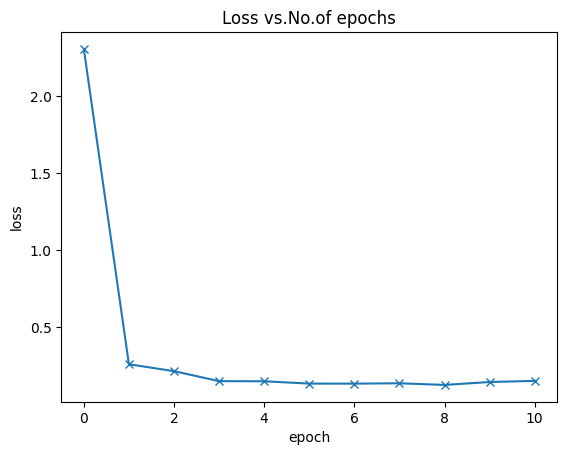

In [108]:
losses =[x['val_loss']for x in history]
plt.plot(losses,'-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs.No.of epochs');

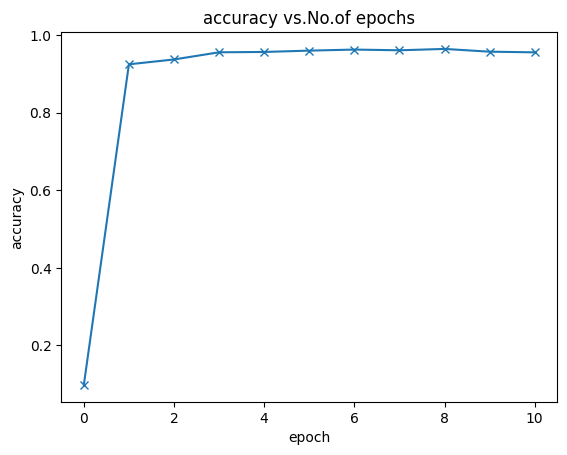

In [110]:
accuracies =[x['val_acc']for x in history]
plt.plot(accuracies,'-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy vs.No.of epochs');